In [1]:
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from tensorflow.keras.preprocessing import image
from tqdm.notebook import tqdm_notebook
import tqdm
from datasets import Dataset
import pandas as pd
import numpy as np
import requests, zipfile, io
import os
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ImageDraw, ImageFont
from p_tqdm import p_map
from joblib import Parallel, delayed
import multiprocessing
import time
import pytesseract
from functools import partial
import re
import cv2
import glob

2023-08-12 15:06:10.958628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 15:06:12.959653: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/opt/conda/lib/python3.7/site-packages/sklearn/_distributor_init.py:25: FutureWarning: 
USE_DAAL4PY_SKLEARN variable is deprecated for Intel(R) Extension for Scikit-learn
and will be delete in the 2022.1 release.
Please, use new construction of global patching:
python sklearnex.glob patch_sklearn
Read more: https://intel.github.io/scikit-learn-intelex/g

In [5]:
# import pandas as pd
# df = pd.read_parquet('/home/mchou001/ResNET/rvl_cdip_100_examples_per_class/data/train-00000-of-00001-6c397619d2120c4e.parquet')

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

In [8]:
text_df = pd.read_csv("ETD_aug.csv")
text_df = text_df['text']
text_df.to_csv("ETD_text.csv")

In [2]:
import torch

cuda_yes = torch.cuda.is_available()
print('Cuda is available?', cuda_yes)
device = torch.device("cuda:0" if cuda_yes else "cpu")
print('Device:', device)

Cuda is available? True
Device: cuda:0


In [3]:
train = pd.read_csv("train_1k.csv")
train

,img_path,label
0,/home/mchou001/train/1/1.png,Label-TitlePage
1,/home/mchou001/train/1/1.png,Label-TitlePage
2,/home/mchou001/train/2/1.png,Label-TitlePage
3,/home/mchou001/train/3/1.png,Label-TitlePage
4,/home/mchou001/train/4/1.png,Label-TitlePage
...,...,...
918,/home/mchou001/train/7/48.png,Label-Appendices
919,/home/mchou001/train/7/49.png,Label-Appendices
920,/home/mchou001/train/9/83.png,Label-Appendices
921,/home/mchou001/train/9/84.png,Label-Appendices


In [4]:
# numbers = re.compile(r'(\d+)')
# def numericalSort(value):
#     parts = numbers.split(value)
#     parts[1::2] = map(int, parts[1::2])
#     return parts

# test_img_path = sorted(glob.glob('/home/mchou001/test/**/*.png'), key = numericalSort)

In [5]:
# test_label = pd.read_csv("labels_test.csv")
# test_class = test_label['labels']
# img_path_label_map = list(zip(test_img_path, test_class))
# df_test = pd.DataFrame(img_path_label_map, columns = ['img_path', 'label'])
# df_test.to_csv('test200ETDs.csv', encoding = 'utf-8', index= None)

In [6]:
feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

In [7]:
y_classes = np.asarray(train['label'])
le = LabelEncoder()
le.fit(list(y_classes))
train_y = le.transform(list(y_classes))
id2label = dict(zip(train_y, y_classes))

In [8]:
label2id = {k: v for v, k in enumerate(train_y)}
label2id = dict(zip(y_classes, train_y))
label2id

{'Label-TitlePage': 11,
 'Label-Dedication': 5,
 'Label-Acknowledgement': 1,
 'Label-TableofContent': 10,
 'Label-ListofTables': 8,
 'Label-ListofFigures': 7,
 'Label-Abstract': 0,
 'Label-Chapters': 4,
 'Label-ChapterAbstract': 3,
 'Label-GeneralAbstract': 6,
 'Label-ReferenceList': 9,
 'Label-Appendices': 2}

In [9]:
labels = list(set(y_classes))
labels

['Label-ReferenceList',
 'Label-GeneralAbstract',
 'Label-ChapterAbstract',
 'Label-TableofContent',
 'Label-Dedication',
 'Label-Chapters',
 'Label-Appendices',
 'Label-Acknowledgement',
 'Label-ListofFigures',
 'Label-Abstract',
 'Label-ListofTables',
 'Label-TitlePage']

In [10]:
train_data = Dataset.from_pandas(train)
train_data

Dataset({
    features: ['img_path', 'label'],
    num_rows: 923
})

In [11]:
train['label'].value_counts()

Label-ReferenceList      84
Label-ListofFigures      78
Label-TableofContent     77
Label-Acknowledgement    77
Label-Abstract           77
Label-GeneralAbstract    77
Label-Dedication         77
Label-ChapterAbstract    77
Label-TitlePage          77
Label-Chapters           76
Label-ListofTables       76
Label-Appendices         70
Name: label, dtype: int64

In [12]:
features_train = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels), names=labels),
})

def preprocess_data(examples):
    
    images = [Image.open(path) for path in examples['img_path']]
    
    encoded_inputs = processor(images, padding="max_length", truncation=True)
    
    encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]
    
    return encoded_inputs

In [75]:
encoded_train_dataset = train_data.map(preprocess_data,remove_columns=train_data.column_names,features=features_train, 
                                       batched = True, batch_size = 1)

  0%|          | 0/2999 [00:00<?, ?ba/s]

In [76]:
encoded_train_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
    num_rows: 2999
})

In [77]:
torch.save(encoded_train_dataset, 'tensor1k.pt')

In [12]:
encoded_train = torch.load('tensor1k.pt')

In [13]:
encoded_train.set_format(type="torch", device="cuda")

In [14]:
import torch 
CUDA_LAUNCH_BLOCKING=1
train_dataloader = torch.utils.data.DataLoader(encoded_train, batch_size=4)
batch_train = next(iter(train_dataloader))

In [15]:
for k,v in batch_train.items():
    print(k, v.shape)

image torch.Size([4, 3, 224, 224])
input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
token_type_ids torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
labels torch.Size([4])


In [44]:
processor.tokenizer.decode(batch_train['input_ids'][2].tolist())

"[CLS] ppccedupes as a peppesfntaticn fop mata in a computer ppcgpaim fcr undepstatipe ic matupal language hy terry \\ iinograd p. a., the colorado college ( 1966 ) suppittter ¢ ( n paptial fulfillment cf the pequepemfnts fcp thf pfopee of poctopr nf philoscphy at the massachusetts imnstitutf of tfchnology august, 12790 signature of author.. wun. soe ee department of mat feratic tugust 2h, 1979 certified by.., woe we ee ee thests supervisor accepted hy * * e a 78 e « ° e. * ‘. '. a. a « ° chairman, denartmental corrittee on craduate students mass. inst. fece sep 29 1279 ven saies [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [17]:
id2label[batch_train['labels'][1].item()]

'Label-TitlePage'

## Test Set

In [39]:
test = pd.read_csv("test600.csv")
test

,img_path,label
0,/home/mchou001/test/494/2.png,Label-TitlePage
1,/home/mchou001/test/406/2.png,Label-TitlePage
2,/home/mchou001/test/406/3.png,Label-TitlePage
3,/home/mchou001/test/407/2.png,Label-TitlePage
4,/home/mchou001/test/407/3.png,Label-TitlePage
...,...,...
519,/home/mchou001/test/411/265.png,Label-CurriculumVitae
520,/home/mchou001/test/412/105.png,Label-CurriculumVitae
521,/home/mchou001/test/413/170.png,Label-CurriculumVitae
522,/home/mchou001/test/414/170.png,Label-CurriculumVitae


In [40]:
test['label'].value_counts()

Label-TitlePage          134
Label-Chapters            80
Label-ChapterAbstract     71
Label-Dedication          65
Label-Abstract            46
Label-Acknowledgement     33
Label-GeneralAbstract     15
Label-ListofFigures       15
Label-ReferenceList       15
Label-TableofContent      15
Label-Appendices          15
Label-ListofTables        15
Label-CurriculumVitae      5
Name: label, dtype: int64

In [41]:
test_classes = np.asarray(test['label'])
le = LabelEncoder()
le.fit(list(test_classes))
test_y = le.transform(list(test_classes))
id2label_test = dict(zip(test_y, test_classes))
label2id_test = {k: v for v, k in enumerate(test_y)}
label2id_test = dict(zip(test_classes, test_y))
labels_test = list(set(test_classes))
labels_test

['Label-ReferenceList',
 'Label-GeneralAbstract',
 'Label-ChapterAbstract',
 'Label-TableofContent',
 'Label-Dedication',
 'Label-Chapters',
 'Label-Appendices',
 'Label-Acknowledgement',
 'Label-ListofFigures',
 'Label-CurriculumVitae',
 'Label-Abstract',
 'Label-ListofTables',
 'Label-TitlePage']

In [42]:
test_data = Dataset.from_pandas(test)
test_data

Dataset({
    features: ['img_path', 'label'],
    num_rows: 524
})

In [22]:
features_test = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels_test': ClassLabel(num_classes=len(labels_test), names= labels_test),
})

def preprocess_test_data(examples):
    
    images = [Image.open(path) for path in examples['img_path']]
    
    encoded_inputs = processor(images, padding="max_length", truncation=True)
    
    encoded_inputs["labels_test"] = [label2id[label] for label in examples["label"]]
    
    return encoded_inputs

In [24]:
encoded_test_dataset = test_data.map(preprocess_test_data, remove_columns=train_data.column_names, features=features_test, 
                              batched=True, batch_size=1)

  0%|          | 0/524 [00:00<?, ?ba/s]

In [25]:
encoded_test_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels_test'],
    num_rows: 524
})

In [26]:
torch.save(encoded_test_dataset, 'tensor_test180.pt')

In [22]:
encoded_test = torch.load('tensor_test180.pt')

In [23]:
encoded_test.set_format(type="torch", device="cuda")

In [24]:
test_dataloader = torch.utils.data.DataLoader(encoded_test, batch_size=4)
batch_test = next(iter(test_dataloader))

In [25]:
for k,v in batch_test.items():
    print(k, v.shape)

image torch.Size([4, 3, 224, 224])
input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
token_type_ids torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
labels_test torch.Size([4])


In [26]:
processor.tokenizer.decode(batch_test['input_ids'][0].tolist())

'[CLS] 72 - 18, 998 marvich, robert hyman, 1945 — reactions of molecular nitrogen with ‘ titanocene and its derivatives. ‘ the univereity of michigan, ph. d., 1971 chenistry, inorganic university microfilms, a xerox company, ann arbor, michigan. ‘ reproduced wih permission of the copyright owner. futher reproduction prohibited without permission. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [27]:
id2label_test[batch_test['labels_test'][0].item()]

'Label-TitlePage'

In [28]:
# "Whether to run training."
do_train = True
# "Whether to run eval on the dev set."
do_eval = True
# "Whether to run the model in inference mode on the test set."
do_predict = True
# Whether load checkpoint file before train model
load_checkpoint = True
batch_size = 12 #32
# "The initial learning rate for Adam."
learning_rate0 = 5e-6 #0.000005
weight_decay_finetune = 1e-5 #0.00001
total_train_epochs = 10
gradient_accumulation_steps = 1
warmup_proportion = 0.1
output_dir = '/home/mchou001/'
model_scale = 'microsoft/layoutlmv2-base-uncased' ## try uncased

In [29]:
def f1_score(y_true, y_pred):

    num_proposed = len(y_pred[y_pred>ignore_id])
    num_correct = (np.logical_and(y_true==y_pred, y_true)).sum()
    num_gold = len(y_true[y_true>ignore_id])

    try:
        precision = num_correct / num_proposed
    except ZeroDivisionError:
        precision = 1.0

    try:
        recall = num_correct / num_gold
    except ZeroDivisionError:
        recall = 1.0

    try:
        f1 = 2*precision*recall / (precision + recall)
    except ZeroDivisionError:
        if precision*recall==0:
            f1=1.0
        else:
            f1=0

    return precision, recall, f1

In [30]:
from transformers import LayoutLMv2ForSequenceClassification
import torch
from torch.optim import AdamW, Adam

torch.cuda.empty_cache()
if load_checkpoint and os.path.exists(output_dir+'/layoutETD1k.pt'):
    checkpoint = torch.load(output_dir+'/layoutETD1k.pt', map_location='cuda')
    start_epoch = checkpoint['epoch']+1
    valid_acc_prev = checkpoint['valid_acc']
    #valid_f1_prev = checkpoint['valid_f1']
    model = LayoutLMv2ForSequenceClassification.from_pretrained(model_scale, state_dict=checkpoint['model_state'], num_labels=len(labels))
    print('Loaded the LayoutLM model, epoch:',checkpoint['epoch'],'valid acc:', checkpoint['valid_acc'])
else:
    start_epoch = 0
    valid_acc_prev = 0
    valid_f1_prev = 0
    model = LayoutLMv2ForSequenceClassification.from_pretrained(model_scale, num_labels=len(labels))

model.to(device)
named_params = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in named_params if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay_finetune},
    {'params': [p for n, p in named_params if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate0)

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res2.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.5.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.1.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv2.norm.num_batches_track

In [31]:
def evaluate(model, predict_dataloader, batch_size, epoch_th, dataset_name):
    # print("***** Running prediction *****")
    model.eval()
    all_preds = []
    all_labels = []
    total=0
    correct=0
    start = time.time()
    with torch.no_grad():
        for batch in predict_dataloader:
            image = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            bbox = batch['bbox'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels_test'].to(device)
            out_scores = model(image= image, input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
            # out_scores = out_scores.detach().cpu().numpy()
            predicted = out_scores.logits.argmax(-1)
            valid_predicted = predicted
            valid_label_ids = labels
            # print(len(valid_label_ids),len(valid_predicted),len(valid_label_ids)==len(valid_predicted))
            all_preds.extend(valid_predicted.tolist())
            all_labels.extend(valid_label_ids.tolist())
            total += len(valid_label_ids)
            correct += valid_predicted.eq(valid_label_ids).sum().item()

    test_acc = correct/total
    #precision, recall, f1 = f1_score(np.array(all_labels), np.array(all_preds))
    end = time.time()
    print('Epoch:%d, Acc:%.2f on %s, Spend: %.3f minutes for evaluation' % (epoch_th, 100.*test_acc, dataset_name, (end-start)/60.0))
    print('--------------------------------------------------------------')
    return test_acc

In [32]:
total_train_steps = int(len(train) / batch_size / gradient_accumulation_steps * total_train_epochs)
global_step_th = int(len(train) / batch_size / gradient_accumulation_steps * start_epoch)
# for epoch in trange(start_epoch, total_train_epochs, desc="Epoch"):
for epoch in range(start_epoch, total_train_epochs):
    tr_loss = 0
    train_start = time.time()
    model.train()
    optimizer.zero_grad()
    # for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
    for step, batch in enumerate(train_dataloader):
        
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(image= image, input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        loss = outputs.loss

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % gradient_accumulation_steps == 0:
            # modify learning rate with special warm up BERT uses
            lr_this_step = learning_rate0
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_this_step
            optimizer.step()
            optimizer.zero_grad()
            global_step_th += 1

        print("Epoch:{}-{}/{}, Loss: {} ".format(epoch, step, len(train_dataloader), loss.item()))

    print('--------------------------------------------------------------')
    print("Epoch:{} completed, Total training's Loss: {}, Spend: {}m".format(epoch, tr_loss, (time.time() - train_start) / 60.0))
    valid_acc = evaluate(model, test_dataloader, batch_size, epoch, 'Valid_set')
    # Save a checkpoint
    if valid_acc > valid_acc_prev:
        # model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
        torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'valid_acc': valid_acc}, os.path.join(output_dir, 'layoutETD1k.pt'))
        valid_acc_prev = valid_acc

evaluate(model, test_dataloader, batch_size, total_train_epochs-1, 'Test_set')

Epoch:0-0/231, Loss: 2.4879825115203857 
Epoch:0-1/231, Loss: 2.2779130935668945 
Epoch:0-2/231, Loss: 2.4338154792785645 
Epoch:0-3/231, Loss: 2.0457537174224854 
Epoch:0-4/231, Loss: 2.242124557495117 
Epoch:0-5/231, Loss: 2.062376022338867 
Epoch:0-6/231, Loss: 1.9513334035873413 
Epoch:0-7/231, Loss: 1.8379333019256592 
Epoch:0-8/231, Loss: 1.7097687721252441 
Epoch:0-9/231, Loss: 1.653087854385376 
Epoch:0-10/231, Loss: 1.6996227502822876 
Epoch:0-11/231, Loss: 1.8437039852142334 
Epoch:0-12/231, Loss: 1.6164402961730957 
Epoch:0-13/231, Loss: 1.5403103828430176 
Epoch:0-14/231, Loss: 1.40115487575531 
Epoch:0-15/231, Loss: 1.410728931427002 
Epoch:0-16/231, Loss: 1.2270996570587158 
Epoch:0-17/231, Loss: 1.2943031787872314 
Epoch:0-18/231, Loss: 1.1414142847061157 
Epoch:0-19/231, Loss: 2.355823516845703 
Epoch:0-20/231, Loss: 2.812464952468872 
Epoch:0-21/231, Loss: 2.623180389404297 
Epoch:0-22/231, Loss: 2.5611672401428223 
Epoch:0-23/231, Loss: 2.629121780395508 
Epoch:0-24/2

0.08333333333333333

In [38]:
#%%
'''
Test_set prediction using the best epoch of layoutlmv2 model
'''
checkpoint = torch.load(output_dir+'/layoutETD1k.pt', map_location='cuda')
epoch = checkpoint['epoch']
valid_acc_prev = checkpoint['valid_acc']
#valid_f1_prev = checkpoint['valid_f1']
model = LayoutLMv2ForSequenceClassification.from_pretrained(
    model_scale, state_dict=checkpoint['model_state'], num_labels=len(labels_test))

model.to(device)
print('Loaded the model, epoch:',checkpoint['epoch'],'valid acc:', checkpoint['valid_acc'])

model.to(device)
# evaluate(model, train_dataloader, batch_size, total_train_epochs-1, 'Train_set')
evaluate(model, test_dataloader, batch_size, epoch, 'Test_set')

Loaded the model, epoch: 7 valid acc: 0.08888888888888889
Epoch:7, Acc:8.89 on Test_set, Spend: 0.096 minutes for evaluation
--------------------------------------------------------------


0.08888888888888889

In [43]:
#%%
'''
Test_set prediction using the best epoch of layoutlmv2 model
'''
checkpoint = torch.load(output_dir+'/layoutETD3k.pt', map_location='cuda')
epoch = checkpoint['epoch']
valid_acc_prev = checkpoint['valid_acc']
#valid_f1_prev = checkpoint['valid_f1']
model = LayoutLMv2ForSequenceClassification.from_pretrained(
    model_scale, state_dict=checkpoint['model_state'], num_labels=len(labels_test))

model.to(device)
print('Loaded the model, epoch:',checkpoint['epoch'],'valid acc:', checkpoint['valid_acc'])

model.to(device)
# evaluate(model, train_dataloader, batch_size, total_train_epochs-1, 'Train_set')
evaluate(model, test_dataloader, batch_size, epoch, 'Test_set')

Loaded the model, epoch: 0 valid acc: 0.15267175572519084
Epoch:0, Acc:8.33 on Test_set, Spend: 0.094 minutes for evaluation
--------------------------------------------------------------


0.08333333333333333

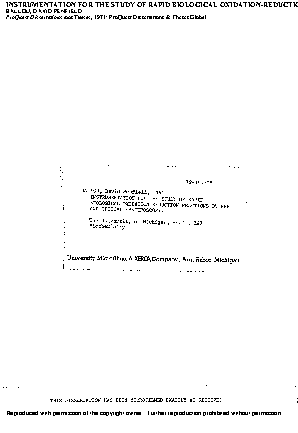

In [95]:
image = Image.open("/home/mchou001/test/403/1.png")
image = image.convert("RGB")
image

In [96]:
# prepare image for the model

encoded_inputs = processor(image, return_tensors="pt")

# # make sure all keys of encoded_inputs are on the same device as the model
for k,v in encoded_inputs.items():
    encoded_inputs[k] = v.to(model.device)

In [97]:
# forward pass
outputs = model(**encoded_inputs)

In [98]:
logits = outputs.logits
print(logits.shape)

torch.Size([1, 12])


In [99]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", id2label_test[predicted_class_idx])

Predicted class: Label-Appendices
